In [1]:
import jax, numpyro
import jax.numpy as jnp
from jax.config import config
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')

In [2]:
import numpy as np
import pandas as pd
from jax import random
from jaxspec.specfit import SpecFit
from jaxspec.numpyro_model import initialize_HMC, model, get_mean_models
import glob, pathlib, dill, corner

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'

## load sample data
- This part should be changed according to the data you have
- We need: wav_obs, flux_obs, error_obs, mask_obs; all have the same shapes of (number of orders) x (number of pixels in each order)
- mask_obs: if True the data point is masked

In [ ]:
def load_ird_spectrum(datapath, orders):
    orders = np.atleast_1d(orders)
    data = pd.read_csv(datapath)
    wav_obs = np.array(data.lam).reshape(-1,2048)[orders,:] * 10 # nm -> AA
    flux_obs = np.array(data.normed_flux).reshape(-1,2048)[orders,:]
    error_obs = np.array(data.flux_error).reshape(-1,2048)[orders,:]
    mask_obs = np.array(data.all_mask).reshape(-1,2048)[orders,:]
    for i in range(len(wav_obs)-1):
        mask_obs[i+1] += wav_obs[i+1] < np.max(wav_obs[i])
    return [wav_obs, flux_obs, error_obs, mask_obs]

In [10]:
datapath = "../data/IRDA00042313_H.csv"
orders = [8]

In [11]:
wav_obs, flux_obs, error_obs, mask_obs = load_ird_spectrum(datapath, orders)

In [17]:
# (number of orders) x (number of pixels in each order)
print (np.shape(wav_obs))

(1, 2048)


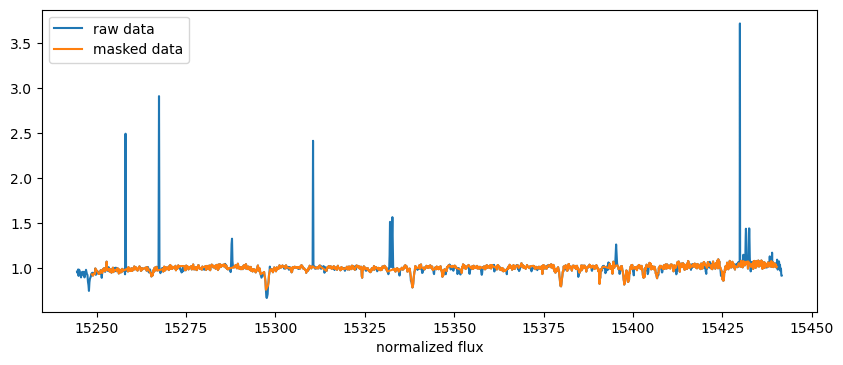

In [24]:
clip = ~mask_obs[0]
plt.xlabel("wavelength ($\mathrm{\AA}$)")
plt.xlabel("normalized flux")
plt.plot(wav_obs[0], flux_obs[0], label='raw data')
plt.plot(wav_obs[0][clip], flux_obs[0][clip], label='masked data')
plt.legend(loc='best')

## path to the spectrum grid 
- here we use the output of compute_coelho_grid.py

In [26]:
gridpath = "/Users/k_masuda/data/specgrid_irdh_coelho"

## specfit class

In [27]:
sf = SpecFit(gridpath, [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=50., wav_margin=3.)

In [30]:
# set fixed wavelength resolution
wavres = np.array([70000])
sf.add_wavresinfo(wavres, wavres)

## check cross correlation function

# order 8


(-23.315632570951323, 19.38193819381938)

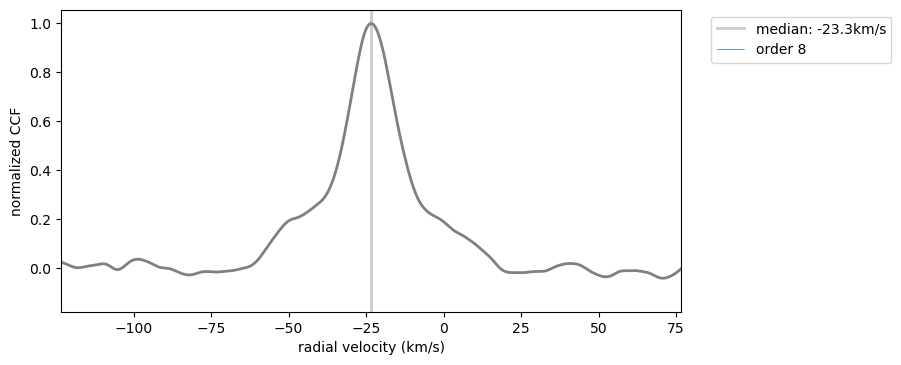

In [32]:
sf.check_ccf()

## optimization


# optimizing...
# iteration 0...
# initial objective function: -3686.237067750184
ScipyMinimizeInfo(fun_val=DeviceArray(-3967.11563264, dtype=float64, weak_type=True), success=False, status=3, iter_num=20)
c0	1.013448
c1	0.037374
teff	6013.333714
logg	3.557317
feh	0.126558
alpha	0.000000
vsini	5.061875
zeta	8.107049
wavres	70000.000000
rv	-23.197737
u1	0.000000
u2	0.000000
lna	-4.519856
lnc	-0.366101
lnsigma	-10.000000
# 2 new outliers (5sigma cut).

# iteration 1...
# initial objective function: -3967.115632641725
ScipyMinimizeInfo(fun_val=DeviceArray(-3967.11563864, dtype=float64, weak_type=True), success=True, status=1, iter_num=13)
c0	1.013447
c1	0.037377
teff	6013.858237
logg	3.558176
feh	0.126743
alpha	0.000000
vsini	5.057187
zeta	8.110584
wavres	70000.000000
rv	-23.197942
u1	0.000000
u2	0.000000
lna	-4.519836
lnc	-0.366062
lnsigma	-10.000000
# 9 new outliers (3sigma cut).

# iteration 2...
# initial objective function: -3967.1156386404964
ScipyMinimizeInfo(fun_val=DeviceArray(-

DeviceArray([ 1.01344737e+00,  3.73768405e-02,  6.01386638e+03,
              3.55818901e+00,  1.26745561e-01,  0.00000000e+00,
              5.05722202e+00,  8.11052692e+00,  7.00000000e+04,
             -2.31979436e+01,  0.00000000e+00,  0.00000000e+00,
             -4.51983649e+00, -3.66047299e-01, -1.00000000e+01],            dtype=float64)

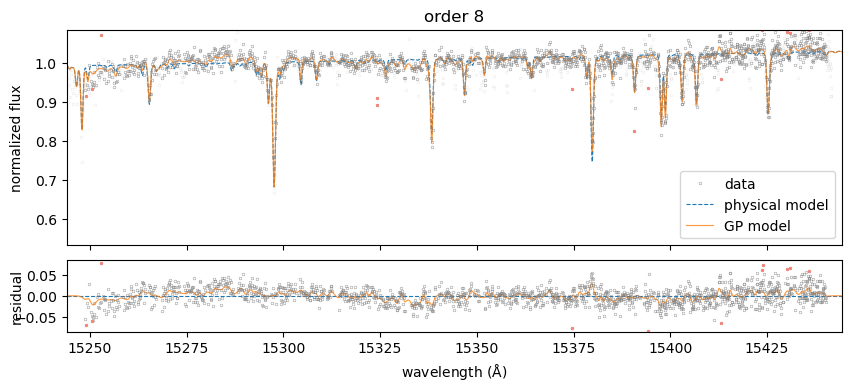

In [33]:
print ()
print ("# optimizing...")
sf.optim_iterate()

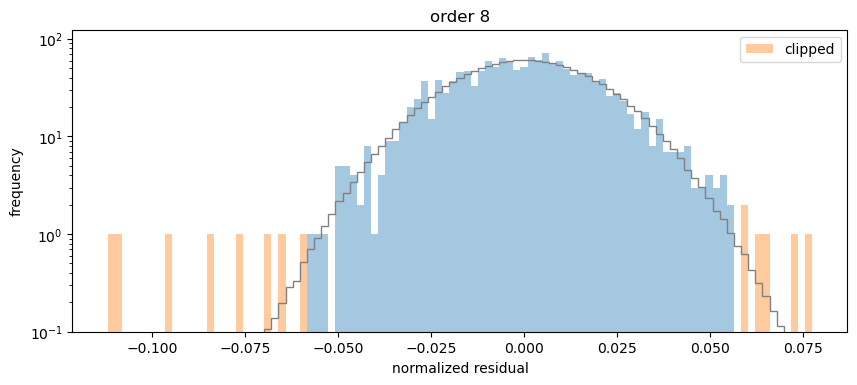

In [34]:
sf.check_residuals()

In [35]:
print ()
print ("# HMC initial parameters:")
init_strategy = initialize_HMC(sf, drop_keys=['logg'])
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_strategy)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)


# HMC initial parameters:
# initial parameters for HMC:
c0 1.0133128978486703
c1 0.037003072080166816
teff 6006.227716300552
feh 0.12297810543123627
alpha 0.002
vsini 5.1035594945452685
zeta 8.079421651815583
wavres 70000.0
rv [-23.31563257]
lna -4.499638125885789
lnc -0.3823868262429119
lnsigma -9.975


In [36]:
print ("# running HMC...")
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf, physical_logg_max=True, empirical_vmacro=False)
mcmc.print_summary()
smp = mcmc.get_samples()

# running HMC...


sample: 100%|████████████████████████████████| 1000/1000 [04:09<00:00,  4.00it/s, 31 steps of size 1.36e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.01      0.01      0.01      0.00      0.03    484.28      1.00
       feh      0.13      0.05      0.13      0.04      0.20    335.62      1.00
       lna     -4.63      0.14     -4.63     -4.83     -4.41    342.40      1.01
       lnc      1.49      0.27      1.51      1.07      1.88    338.70      1.01
   lnsigma     -8.32      1.01     -8.33     -9.98     -6.92    325.64      1.00
      logg      3.48      0.24      3.47      3.11      3.85    316.15      1.00
   norm[0]      1.01      0.00      1.01      1.01      1.02    432.36      1.00
        q1      0.50      0.29      0.50      0.07      0.96    643.67      1.00
        q2      0.51      0.29      0.52      0.01      0.91    705.32      1.00
     rv[0]    -23.16      0.12    -23.16    -23.35    -22.98    488.84      1.00
  slope[0]      0.04      0.01      0.04      0.03      0.06    454.54      1.00
      teff   6025.58    107

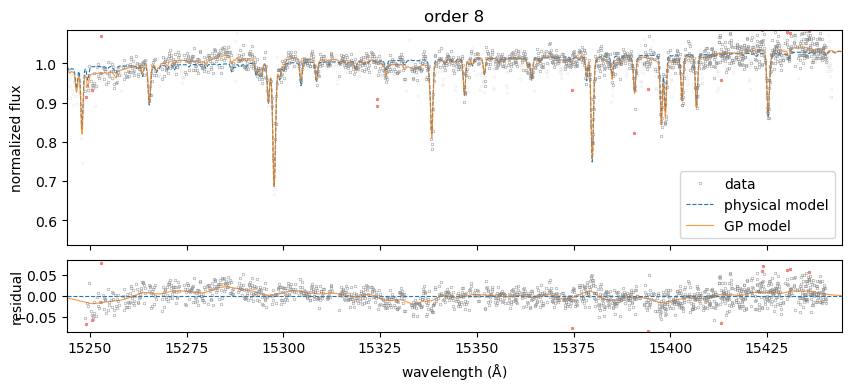

In [37]:
ms, mgps = get_mean_models(smp, sf)
sf.plot_models(ms, mgps)

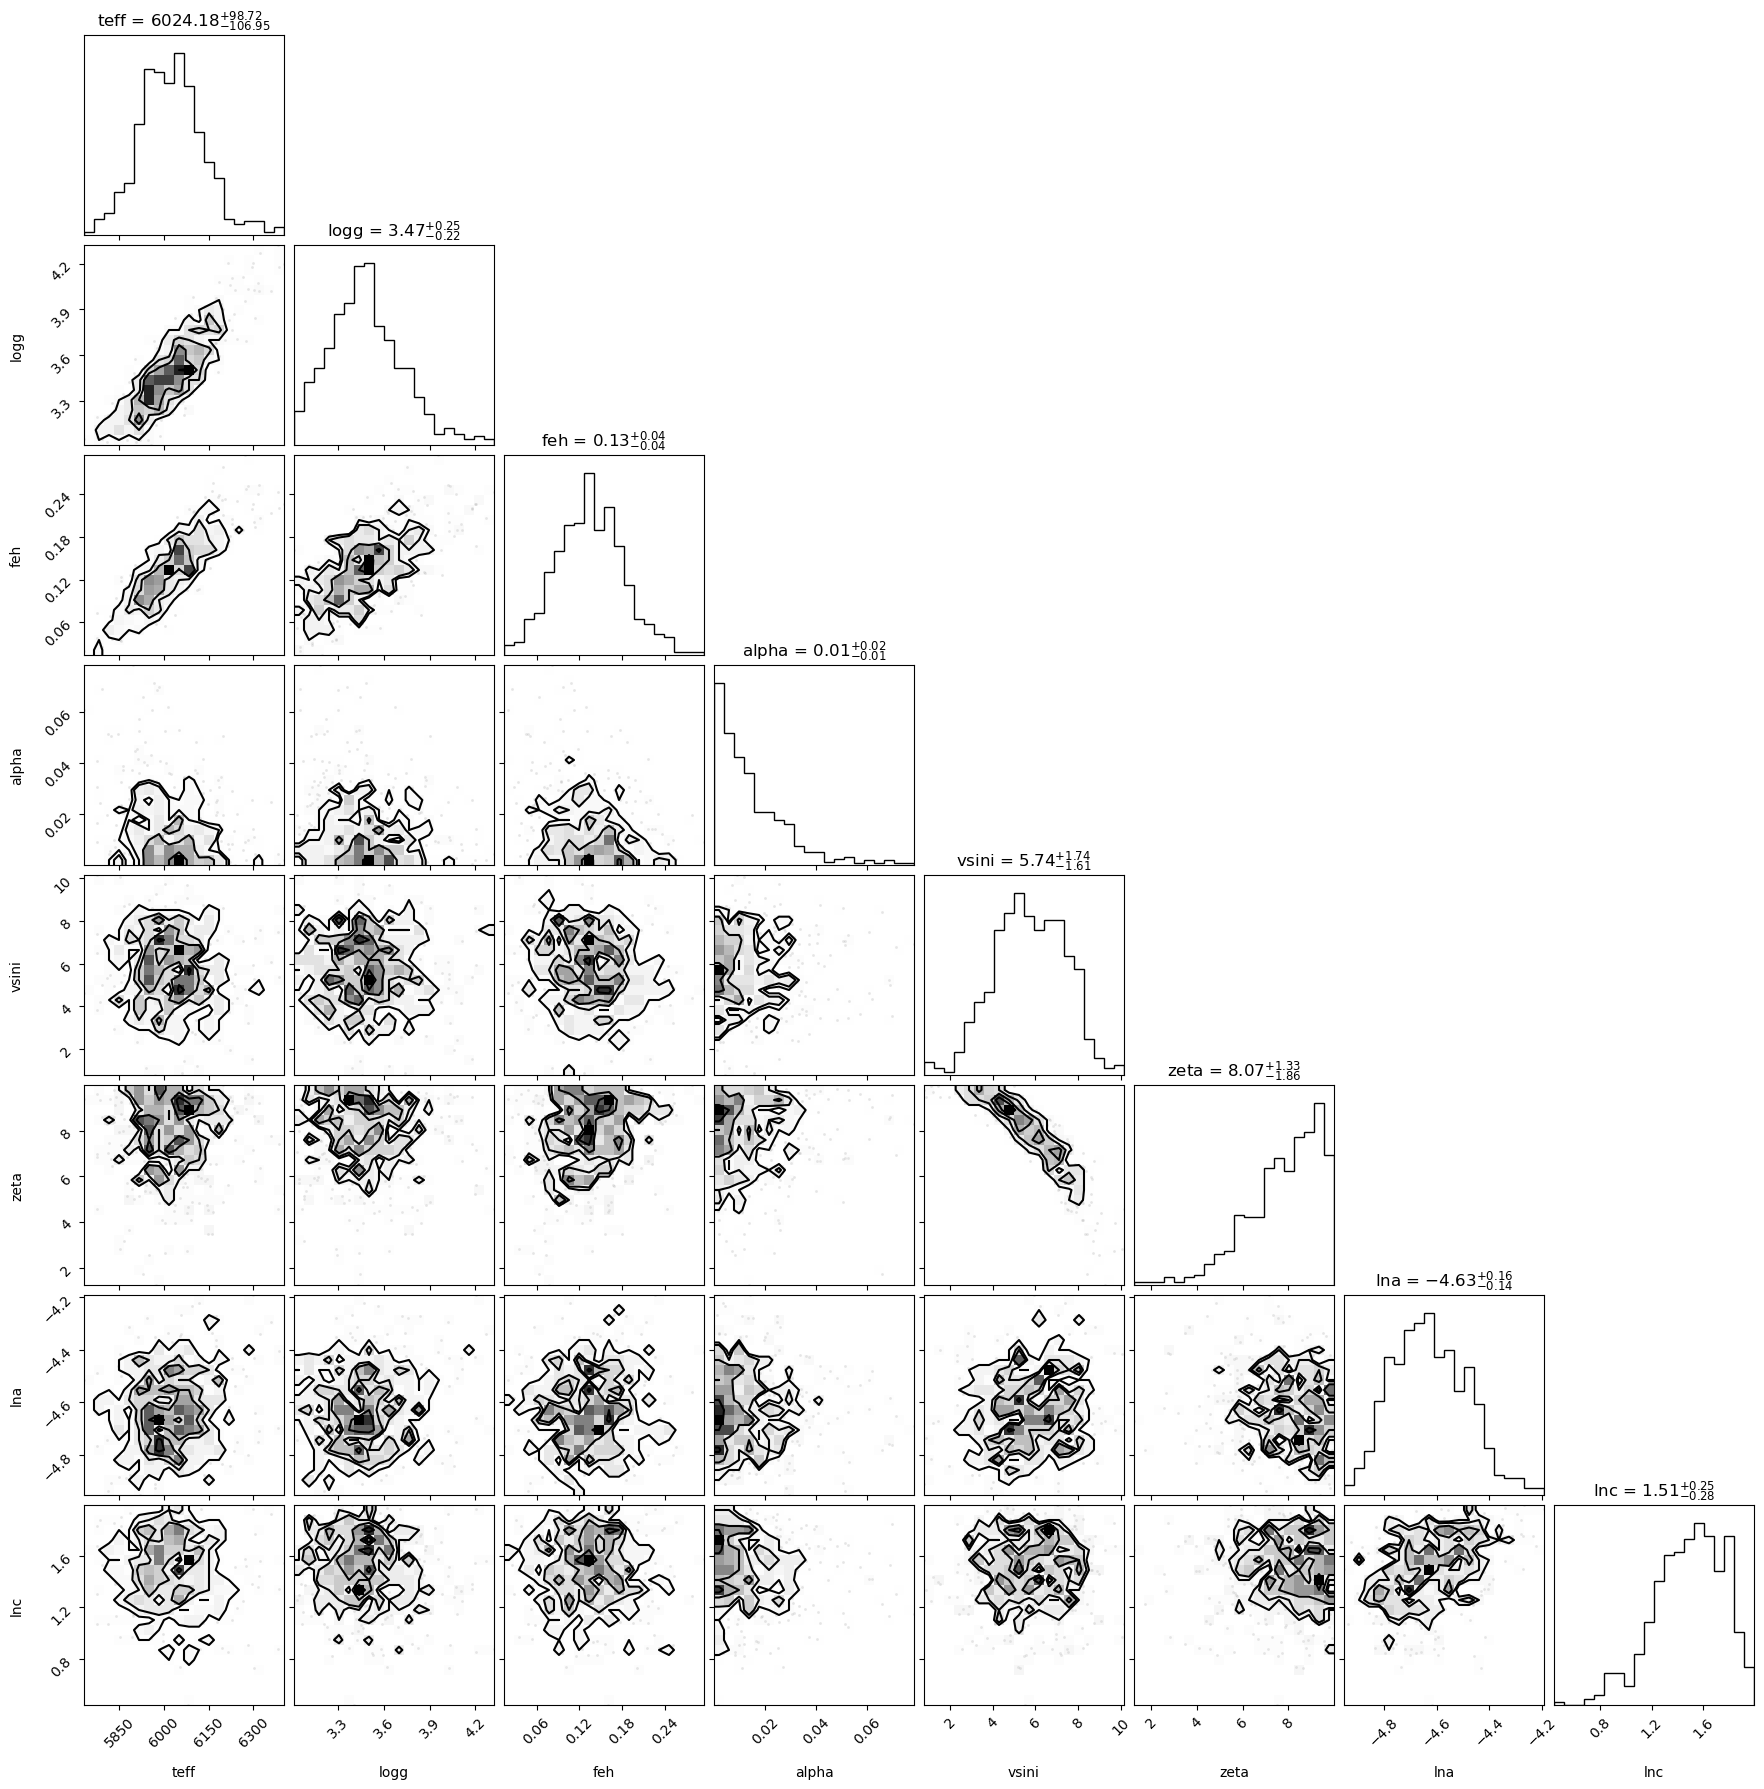

In [38]:
names = sf.pnames[2:8] + sf.pnames[10+2:14]
hyper = pd.DataFrame(data=dict(zip(names, [smp[k] for k in names])))
fig = corner.corner(hyper, labels=names, show_titles="%.2f")